In [246]:
import geopandas as gpd
from geopy.distance import geodesic
import shapely
import shapely.wkt as wkt
import seaborn as sns
import pandas as pd
import numpy as np
from shapely.geometry import shape 
import matplotlib.pyplot as plt
import datetime
import sys
import re
import iris
sys.path.append('../../Scripts/') # link to scripts
import preprocessing.translate   # import translation scripts from preprocessing
import utils.spatial_utils
import utils.temporal_utils
import preprocessing.create_metrics
from sklearn.cluster import KMeans
import pyLDAvis.gensim
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from gensim.models import CoherenceModel
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

Using TensorFlow backend.
/Users/thomaskeel/.local/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from google.protobuf.pyext import _message
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages

In [2]:
# path to the MTL Trajet data 
path_2016 = "../../Data/mtl_trajet/mtl_trajet_2016.shp"
path_2017 = "../../Data/mtl_trajet/trajets_mtl_trajet_2017.shp"

##### Important Reference: Code to save current geodataframe

In [ ]:
# # save at this point 
# gdf_2016['starttime'] = gdf_2016['starttime'].astype(str)
# gdf_2016['endtime'] = gdf_2016['endtime'].astype(str)
# gdf_2017['starttime'] = gdf_2017['starttime'].astype(str)
# gdf_2017['endtime'] = gdf_2017['endtime'].astype(str)

# gdf_2016['start_can'] = gdf_2016['start_can'].astype(str)
# gdf_2016['end_can'] = gdf_2016['end_can'].astype(str)
# gdf_2016['start_wgs'] = gdf_2016['start_wgs'].astype(str)
# gdf_2016['end_wgs'] = gdf_2016['end_wgs'].astype(str)

# gdf_2017['start_can'] = gdf_2017['start_can'].astype(str)
# gdf_2017['end_can'] = gdf_2017['end_can'].astype(str)
# gdf_2017['start_wgs'] = gdf_2017['start_wgs'].astype(str)
# gdf_2017['end_wgs'] = gdf_2017['end_wgs'].astype(str)

# gdf_2016.to_file("../../Data/mtl_trajet/mtl_trajet_2016_current.shp", encoding='utf-8')
# gdf_2017.to_file("../../Data/mtl_trajet/mtl_trajet_2017_current.shp", encoding='utf-8')


##### Important Reference: Code to load data back in

In [4]:
# ### AFTER:
# gdf_2016 = preprocessing.translate.translate_data("../../Data/mtl_trajet/mtl_trajet_2016_current.shp")
# gdf_2017 = preprocessing.translate.translate_data("../../Data/mtl_trajet/mtl_trajet_2017_current.shp")
# gdf_2016['starttime'] = pd.to_datetime(gdf_2016['starttime'])
# gdf_2016['endtime'] = pd.to_datetime(gdf_2016['endtime'])
# gdf_2017['starttime'] = pd.to_datetime(gdf_2017['starttime'])
# gdf_2017['endtime'] = pd.to_datetime(gdf_2017['endtime'])

# gdf_2016['start_can'] = gdf_2016['start_can'].apply(wkt.loads)
# gdf_2016['end_can'] = gdf_2016['end_can'].apply(wkt.loads)
# gdf_2017['start_can'] = gdf_2017['start_can'].apply(wkt.loads)
# gdf_2017['end_can'] = gdf_2017['end_can'].apply(wkt.loads)
# gdf_2016['start_wgs'] = gdf_2016['start_wgs'].apply(wkt.loads)
# gdf_2016['end_wgs'] = gdf_2016['end_wgs'].apply(wkt.loads)
# gdf_2017['start_wgs'] = gdf_2017['start_wgs'].apply(wkt.loads)
# gdf_2017['end_wgs'] = gdf_2017['end_wgs'].apply(wkt.loads)

# # USE THIS IF YOU CANNOT LOAD IN THE WGS POINTS
# gdf_2016['start_wgs'] = gdf_2016['start_wgs'].apply(lambda row: wkt.loads(row.replace('(','POINT (').replace(',','')))
# gdf_2016['end_wgs'] = gdf_2016['end_wgs'].apply(lambda row: wkt.loads(row.replace('(','POINT (').replace(',','')))
# gdf_2017['start_wgs'] = gdf_2017['start_wgs'].apply(lambda row: wkt.loads(row.replace('(','POINT (').replace(',','')))
# gdf_2017['end_wgs'] = gdf_2017['end_wgs'].apply(lambda row: wkt.loads(row.replace('(','POINT (').replace(',','')))

## Translate and re-project data

In [3]:
gdf_2016 = preprocessing.translate.translate_data(path_2016)
gdf_2017 = preprocessing.translate.translate_data(path_2017)

# initalise the CRS
if gdf_2016.crs == {}:
    print("initialising crs")
    gdf_2016.crs = {'init': 'epsg:4326'}
    
if gdf_2017.crs == {}:
    print("initialising crs")
    gdf_2017.crs = {'init': 'epsg:4326'}

initialising crs


In [4]:
# calculate the bounding box 
used_data = gdf_2017
for i in range(len(used_data)):
    if i == 0:
        min_lon, min_lat, max_lon, max_lat = used_data['geometry'][i].bounds
    else:
        lon1, lat1, lon2, lat2 = used_data['geometry'][i].bounds
        if lon1 < min_lon:
            min_lon = lon1
        elif lat1 < min_lat:
            min_lat = lat1
        if lon1 > max_lon:
            max_lon = lon2
        elif lat1 > max_lat:
            max_lat = lat2
        

In [5]:
min_lon, min_lat, max_lon, max_lat

(-74.314814, 45.230252, -72.82648600000002, 45.999661)

(45.230252, 45.999661)

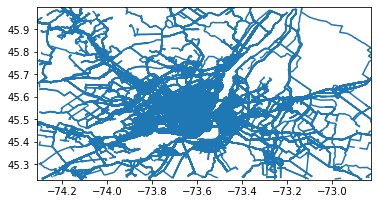

In [6]:
gdf_2017.plot()

plt.xlim(min_lon,max_lon)
plt.ylim(min_lat, max_lat)

In [7]:
min_lon, min_lat, max_lon, max_lat

(-74.314814, 45.230252, -72.82648600000002, 45.999661)

In [8]:
# reproject data
if not gdf_2016.crs == {'init': 'epsg:3347'}:
    gdf_2016 = utils.spatial_utils.change_projection(gdf_2016)
    
if not gdf_2017.crs == {'init': 'epsg:3347'}:
    gdf_2017 = utils.spatial_utils.change_projection(gdf_2017)

translating data
translating data


In [9]:
# remove timezone 
gdf_2016 = utils.temporal_utils.remove_timezone(gdf_2016)
gdf_2017 = utils.temporal_utils.remove_timezone(gdf_2017)

converting start and end timestamps to datetime objects
converting start and end timestamps to datetime objects


In [10]:
gdf_2016

,id_trip,avg_speed,duration,mode,purpose,n_coord,segments,starttime,endtime,geometry
0,1724206,4.4,460,walking,returning_home,12,"[{""id"": 1150192, ""source"": ""geobase_mtl""}, {""i...",2016-09-07 20:37:26,2016-09-07 20:45:06,LINESTRING (7628287.236741193 1247680.17623496...
1,1724208,10.7,2146,combination,work,120,"[{""id"": 1140016, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 07:43:23,2016-09-08 08:19:09,LINESTRING (7627830.06960756 1247172.275532002...
2,1889461,15.4,447,public_transport,leisure,36,"[{""id"": 1390715, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 19:46:14,2016-09-08 19:53:41,LINESTRING (7632055.840015979 1247584.15415876...
3,1724219,16.8,591,car,returning_home,45,"[{""id"": 1210250, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 21:41:37,2016-09-08 21:51:28,LINESTRING (7630236.131991102 1247926.25343475...
4,2071985,6.9,279,combination,pick_up_drop_off,12,"[{""id"": 1140287, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 16:49:12,2016-09-09 16:53:51,"LINESTRING (7628479.883114187 1247193.3864914,..."
5,2071991,12.4,844,cycling,food_drink,56,"[{""id"": 1150004, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 18:22:22,2016-09-09 18:36:26,LINESTRING (7628002.075274516 1247761.31724215...
6,1667922,4.2,1211,cycling,food_drink,29,"[{""id"": 1240379, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 23:41:59,2016-09-10 00:02:10,LINESTRING (7628517.528697006 1246292.61362129...
7,1667924,3.9,1330,walking,returning_home,29,"[{""id"": 1220168, ""source"": ""geobase_mtl""}, {""i...",2016-09-10 00:10:40,2016-09-10 00:32:50,LINESTRING (7629840.839065067 1246606.40804376...
8,2071994,9.8,930,cycling,returning_home,49,"[{""id"": 1120087, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 20:04:18,2016-09-09 20:19:48,LINESTRING (7626472.681291102 1247124.48181704...
9,2072003,4.8,1266,walking,food_drink,34,"[{""id"": 5640, ""source"": ""reseau_cyclable""}, {""...",2016-09-10 10:29:44,2016-09-10 10:50:50,LINESTRING (7628222.927915867 1247461.40768243...


## merge with weather data

In [11]:
## see weather_data notebook for details

In [12]:
weather_data = pd.read_csv("../../Data/supplementary_data/weather/mtl_temp_prec.csv")

In [13]:
weather_data['dt'] = weather_data['dt'].apply(pd.to_datetime)
weather_data = weather_data.set_index('dt')

In [14]:
def extract_weather_subset(row, weather_df):
    assert type(weather_df.index) == pd.core.indexes.datetimes.DatetimeIndex, ("the weather data needs a datetime index")
    
    start = row['starttime']
    end = row['endtime']
    subset_weather = weather_df.loc[start.strftime("%Y-%m-%d %H:%M:%S"):end.strftime("%Y-%m-%d %H:%M:%S")]
    if len(subset_weather) < 1:
        start = start - datetime.timedelta(hours=1)
        subset_weather = weather_df.loc[start.strftime("%Y-%m-%d %H:%M:%S"):end.strftime("%Y-%m-%d %H:%M:%S")]
    return subset_weather

def calc_mean_weather(subset):
#     print(len(subset), "hours worth of weather")
    return subset.precipitation.mean(), subset.temperature.mean()


In [15]:
%%time
## apply average weather for trip to each row
## takes 15 mins
gdf_2016['av_weather'] = gdf_2016.apply(lambda row: calc_mean_weather(extract_weather_subset(row, weather_data)), axis=1)
gdf_2017['av_weather'] = gdf_2017.apply(lambda row: calc_mean_weather(extract_weather_subset(row, weather_data)), axis=1)


CPU times: user 13min 44s, sys: 10.9 s, total: 13min 55s
Wall time: 13min 49s


In [16]:
temp_prec_16 = gdf_2016.av_weather.apply(pd.Series)
temp_prec_16.columns = ['precip','temperature']

temp_prec_17 = gdf_2017.av_weather.apply(pd.Series)
temp_prec_17.columns = ['precip','temperature']

In [17]:
gdf_2016 = pd.concat([gdf_2016,temp_prec_16], axis=1)
gdf_2017 = pd.concat([gdf_2017,temp_prec_17], axis=1)

In [18]:
gdf_2016.head()

,id_trip,avg_speed,duration,mode,purpose,n_coord,segments,starttime,endtime,geometry,av_weather,precip,temperature
0,1724206,4.4,460,walking,returning_home,12,"[{""id"": 1150192, ""source"": ""geobase_mtl""}, {""i...",2016-09-07 20:37:26,2016-09-07 20:45:06,LINESTRING (7628287.236741193 1247680.17623496...,"(1.5039444824678503e-06, 28.012522481572827)",0.000002,28.012522
1,1724208,10.7,2146,combination,work,120,"[{""id"": 1140016, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 07:43:23,2016-09-08 08:19:09,LINESTRING (7627830.06960756 1247172.275532002...,"(0.0, 20.969070204942227)",0.000000,20.969070
2,1889461,15.4,447,public_transport,leisure,36,"[{""id"": 1390715, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 19:46:14,2016-09-08 19:53:41,LINESTRING (7632055.840015979 1247584.15415876...,"(0.0001343523737672367, 25.84488639333847)",0.000134,25.844886
3,1724219,16.8,591,car,returning_home,45,"[{""id"": 1210250, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 21:41:37,2016-09-08 21:51:28,LINESTRING (7630236.131991102 1247926.25343475...,"(0.00024012980236755996, 25.38936301243564)",0.000240,25.389363
4,2071985,6.9,279,combination,pick_up_drop_off,12,"[{""id"": 1140287, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 16:49:12,2016-09-09 16:53:51,"LINESTRING (7628479.883114187 1247193.3864914,...","(0.001389143386973931, 23.612509824599048)",0.001389,23.612510


In [19]:
gdf_2017.head()

,id_trip,mode,purpose,starttime,endtime,geometry,av_weather,precip,temperature
0,1547,None,None,2017-09-18 04:16:58,2017-09-18 04:26:26,LINESTRING (7624015.797731054 1247372.35912242...,"(0.0, 18.951943514056154)",0.0,18.951944
1,308312,None,None,2017-09-18 06:17:46,2017-09-18 06:58:49,LINESTRING (7624029.565886395 1247375.82561127...,"(0.0, 18.353765796400975)",0.0,18.353766
2,384772,None,None,2017-09-18 09:30:24,2017-09-18 10:17:28,(LINESTRING (7607307.107749194 1253237.7069476...,"(0.0, 16.910883638032313)",0.0,16.910884
3,150744,car,pick_up_drop_off,2017-09-18 10:02:50,2017-09-18 10:17:12,LINESTRING (7624322.265039734 1247672.97005955...,"(0.0, 16.910883638032313)",0.0,16.910884
4,199011,None,None,2017-09-18 10:18:40,2017-09-18 10:27:44,(LINESTRING (7616402.393582943 1246769.1996916...,"(0.0, 16.910883638032313)",0.0,16.910884


## Calculate distance, direction and duration

In [20]:
if 'distance_m' not in gdf_2016.columns:
    print("calculating distance")
    gdf_2016['distance_m'] = gdf_2016['geometry'].apply(lambda row: row.length)
else:
    print('distance already calculated')
    

if 'distance_m' not in gdf_2017.columns:
    print("calculating distance")
    gdf_2017['distance_m'] = gdf_2017['geometry'].apply(lambda row: row.length)
else:
    print('distance already calculated')

calculating distance
calculating distance


In [21]:
if 'duration' not in gdf_2016.columns:
    gdf_2016['duration'] = pd.to_datetime(gdf_2016['endtime']) - pd.to_datetime(gdf_2016['starttime'])
    gdf_2016['duration'] = gdf_2016['duration'].apply(lambda tm: tm.seconds)
else:
    print('duration already calculated')
    
if 'duration' not in gdf_2017.columns:
    gdf_2017['duration'] = pd.to_datetime(gdf_2017['endtime']) - pd.to_datetime(gdf_2017['starttime'])
    gdf_2017['duration'] = gdf_2017['duration'].apply(lambda tm: tm.seconds)
else:
    print('duration already calculated')

duration already calculated


In [22]:
%%time
gdf_2016 = preprocessing.create_metrics.calc_direction(gdf_2016)
gdf_2017 = preprocessing.create_metrics.calc_direction(gdf_2017)

reprojecting data into WGS_84 for direction calculation
calculating mean direction (may take 5-10 minutes)
reprojecting data into WGS_84 for direction calculation
calculating mean direction (may take 5-10 minutes)
CPU times: user 12min 21s, sys: 6.3 s, total: 12min 27s
Wall time: 12min 39s


In [23]:
gdf_2016.head()

,id_trip,avg_speed,duration,mode,purpose,n_coord,segments,starttime,endtime,geometry,av_weather,precip,temperature,distance_m,direction,magnitude,carddir
0,1724206,4.4,460,walking,returning_home,12,"[{""id"": 1150192, ""source"": ""geobase_mtl""}, {""i...",2016-09-07 20:37:26,2016-09-07 20:45:06,"LINESTRING (-73.5983784907 45.53640603229992, ...","(1.5039444824678503e-06, 28.012522481572827)",0.000002,28.012522,415.236330,317.610420,0.227492,NW
1,1724208,10.7,2146,combination,work,120,"[{""id"": 1140016, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 07:43:23,2016-09-08 08:19:09,"LINESTRING (-73.6057240345 45.53323548669993, ...","(0.0, 20.969070204942227)",0.000000,20.969070,6407.207910,155.205916,0.246612,SSE
2,1889461,15.4,447,public_transport,leisure,36,"[{""id"": 1390715, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 19:46:14,2016-09-08 19:53:41,LINESTRING (-73.55313767040001 45.526113951199...,"(0.0001343523737672367, 25.84488639333847)",0.000134,25.844886,1843.264582,305.597389,0.470022,NW
3,1724219,16.8,591,car,returning_home,45,"[{""id"": 1210250, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 21:41:37,2016-09-08 21:51:28,"LINESTRING (-73.5739219686 45.53360049689993, ...","(0.00024012980236755996, 25.38936301243564)",0.000240,25.389363,2657.421830,290.430625,0.303495,WNW
4,2071985,6.9,279,combination,pick_up_drop_off,12,"[{""id"": 1140287, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 16:49:12,2016-09-09 16:53:51,"LINESTRING (-73.5977874175 45.53178334249993, ...","(0.001389143386973931, 23.612509824599048)",0.001389,23.612510,481.960461,9.350188,0.220694,N


In [24]:
gdf_2017.head()

,id_trip,mode,purpose,starttime,endtime,geometry,av_weather,precip,temperature,distance_m,duration,direction,magnitude,carddir
0,1547,None,None,2017-09-18 04:16:58,2017-09-18 04:26:26,"LINESTRING (-73.651166 45.54450099999992, -73....","(0.0, 18.951943514056154)",0.0,18.951944,1530.222174,568,303.572980,0.019003,WNW
1,308312,None,None,2017-09-18 06:17:46,2017-09-18 06:58:49,"LINESTRING (-73.650987 45.54449599999993, -73....","(0.0, 18.353765796400975)",0.0,18.353766,324.869460,2463,274.079216,0.313505,W
2,384772,None,None,2017-09-18 09:30:24,2017-09-18 10:17:28,"(LINESTRING (-73.832869 45.63606799999993, -73...","(0.0, 16.910883638032313)",0.0,16.910884,32009.701647,2824,130.691098,0.272104,SE
3,150744,car,pick_up_drop_off,2017-09-18 10:02:50,2017-09-18 10:17:12,"LINESTRING (-73.646385 45.54628999999992, -73....","(0.0, 16.910883638032313)",0.0,16.910884,9935.922336,862,85.310969,0.304086,E
4,199011,None,None,2017-09-18 10:18:40,2017-09-18 10:27:44,(LINESTRING (-73.74549500000001 45.55838999999...,"(0.0, 16.910883638032313)",0.0,16.910884,563.806088,544,96.630699,0.255485,E


## Calculate Spatial and Temporal Clusters

In [25]:
%%time
## 30 mins
## calculate start and end points (WGS84)
gdf_2016 = gdf_2016.to_crs(crs={'init':'epsg:4326'})
gdf_2016['start_wgs'] =  gdf_2016.geometry.apply(utils.spatial_utils.get_point_from_linestring, X=0) 
gdf_2016['end_wgs'] =  gdf_2016.geometry.apply(utils.spatial_utils.get_point_from_linestring, X=-1) 

gdf_2017 = gdf_2017.to_crs(crs={'init':'epsg:4326'})
gdf_2017['start_wgs'] =  gdf_2017.geometry.apply(utils.spatial_utils.get_point_from_linestring, X=0) 
gdf_2017['end_wgs'] =  gdf_2017.geometry.apply(utils.spatial_utils.get_point_from_linestring, X=-1) 

## calculate start and end points (Canada Lambert)
gdf_2016 = gdf_2016.to_crs(crs={'init':'epsg:3347'})
gdf_2016['start_can'] =  gdf_2016.geometry.apply(utils.spatial_utils.get_point_from_linestring, X=0) 
gdf_2016['end_can'] =  gdf_2016.geometry.apply(utils.spatial_utils.get_point_from_linestring, X=-1) 

gdf_2017 = gdf_2017.to_crs(crs={'init':'epsg:3347'})
gdf_2017['start_can'] =  gdf_2017.geometry.apply(utils.spatial_utils.get_point_from_linestring, X=0) 
gdf_2017['end_can'] =  gdf_2017.geometry.apply(utils.spatial_utils.get_point_from_linestring, X=-1) 

CPU times: user 30min 40s, sys: 8.71 s, total: 30min 49s
Wall time: 30min 57s


In [29]:
gdf_2016['start_can'] = gdf_2016['start_can'].apply(shapely.geometry.Point)
gdf_2016['end_can'] = gdf_2016['end_can'].apply(shapely.geometry.Point)
gdf_2017['start_can'] = gdf_2017['start_can'].apply(shapely.geometry.Point)
gdf_2017['end_can'] = gdf_2017['end_can'].apply(shapely.geometry.Point)

In [30]:
gdf_2016['startx'] = gdf_2016.start_can.apply(lambda row: row.x)
gdf_2016['starty'] = gdf_2016.start_can.apply(lambda row: row.y)
gdf_2016['endx'] = gdf_2016.end_can.apply(lambda row: row.x)
gdf_2016['endy'] = gdf_2016.end_can.apply(lambda row: row.y)

gdf_2017['startx'] = gdf_2017.start_can.apply(lambda row: row.x)
gdf_2017['starty'] = gdf_2017.start_can.apply(lambda row: row.y)
gdf_2017['endx'] = gdf_2017.end_can.apply(lambda row: row.x)
gdf_2017['endy'] = gdf_2017.end_can.apply(lambda row: row.y)

In [31]:
# Calculate DISTANCE MATRIX
coords_st = [[x,y] for x, y in zip(gdf_2016['startx'], gdf_2016['starty'])]
coords_en = [[x,y] for x, y in zip(gdf_2016['endx'], gdf_2016['endy'])]

# get a list of all end-points for clustering algorithm
overall_coords = coords_st
overall_coords.extend(coords_en)

In [36]:
%%time
kmeans = KMeans(n_clusters=12, random_state=0).fit(overall_coords)
kmeans.labels_

CPU times: user 32.4 s, sys: 4.57 s, total: 37 s
Wall time: 35.7 s


array([9, 9, 0, ..., 0, 3, 9], dtype=int32)

In [37]:
gdf_2016['startclust'] = kmeans.labels_[:int(len(gdf_2016))]
gdf_2016['endclust'] = kmeans.labels_[int(len(gdf_2016)):]

In [38]:
print(gdf_2016.startclust.value_counts())
print(gdf_2016.endclust.value_counts())

0     80751
9     52870
11    44981
8     32145
1     14467
6     14192
7     10704
2      8945
3      5990
5      4342
10     3823
4      2414
Name: startclust, dtype: int64
0     81823
9     51467
11    43454
8     31766
6     14811
1     14769
7     11105
2      9222
3      6327
5      4517
10     3892
4      2471
Name: endclust, dtype: int64


In [39]:
%%time
# Calculate DISTANCE MATRIX
coords_st = [[x,y] for x, y in zip(gdf_2017['startx'], gdf_2017['starty'])]
coords_en = [[x,y] for x, y in zip(gdf_2017['endx'], gdf_2017['endy'])]

# get a list of all end-points for clustering algorithm
overall_coords = coords_st
overall_coords.extend(coords_en)

kmeans = KMeans(n_clusters=12, random_state=0).fit(overall_coords)
kmeans.labels_

gdf_2017['startclust'] = kmeans.labels_[:int(len(gdf_2017))]
gdf_2017['endclust'] = kmeans.labels_[int(len(gdf_2017)):]

print(gdf_2017.startclust.value_counts())
print(gdf_2017.endclust.value_counts())

2     70269
1     36930
6     30104
5     25591
0      5628
9      5609
4      4558
3      3671
8      1080
10      699
7       657
11      489
Name: startclust, dtype: int64
2     69861
1     36689
6     30394
5     24526
9      6005
0      5814
4      4687
3      3930
8      1141
10      880
7       756
11      602
Name: endclust, dtype: int64
CPU times: user 18.8 s, sys: 2.44 s, total: 21.2 s
Wall time: 19.6 s


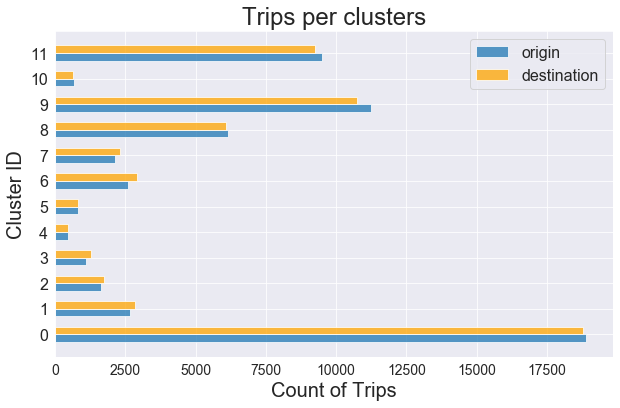

In [42]:
col_order = ['0','1','2','3','4','5','6','7','8','9','10','11']

sns.set_style("darkgrid")
grouped_cluster_origin = gdf_2016.groupby('startclust').count()['mode']
grouped_cluster_destination = gdf_2016.groupby('endclust').count()['mode']

fig, ax = plt.subplots(1, figsize=(10,6))
ind = np.arange(len(grouped_cluster_origin))
height = .3

ax.barh(y=ind, width=grouped_cluster_origin, height=height, alpha=.75)
ax.barh(y=ind+height, width=grouped_cluster_destination,height=height, color='orange', alpha=.75)
ax.set_yticks(ind + height / 2)
ax.set_yticklabels(col_order, size=16)
ax.set_ylabel("Cluster ID", size=20)
plt.xticks(size=14)
ax.set_xlabel("Count of Trips",size=20)
ax.set_title("Trips per clusters", size=24)
ax.legend(['origin', 'destination'], fontsize=16);
# ax.figure.savefig("figures/trips_per_cluster.png", bbox_inches='tight')

### Temporal Clustering
For tuning of LDA inputs see 'metrics/clustering' notebook

In [43]:
if not type(gdf_2016.starttime[0]) == datetime.datetime or not type(gdf_2017.starttime[0]) == datetime.datetime:
    print("converting start and end timestamps to datetime objects")
    gdf_2016['starttime'] = pd.to_datetime(gdf_2016['starttime'])
    gdf_2016['endtime'] = pd.to_datetime(gdf_2016['endtime'])
    gdf_2017['starttime'] = pd.to_datetime(gdf_2017['starttime'])
    gdf_2017['endtime'] = pd.to_datetime(gdf_2017['endtime'])

converting start and end timestamps to datetime objects


In [44]:
gdf_2016['hour'] = gdf_2016.starttime.apply(lambda row: row.hour)
gdf_2017['hour'] = gdf_2017.starttime.apply(lambda row: row.hour)

In [45]:
def create_LDA_words(row):
    if row['purpose']:
        return row['starttime'].day_name() + "_" + str(row['hour']) + ", " + row['purpose']

In [46]:
%%time 
# about 1 minute
gdf_2016['lda_word'] = gdf_2016.apply(lambda row: create_LDA_words(row), axis=1)

CPU times: user 8.55 s, sys: 167 ms, total: 8.71 s
Wall time: 8.74 s


In [47]:
%%time 
# about 1 minute
gdf_2017['lda_word'] = gdf_2017.apply(lambda row: create_LDA_words(row), axis=1)

CPU times: user 7.6 s, sys: 241 ms, total: 7.84 s
Wall time: 8.09 s


In [51]:
tokenizer = RegexpTokenizer(r'\w+')
# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [65]:
def create_LDA(data):
    doc_set = list(data['lda_word'].dropna())
    # list for tokenized documents in loop
    texts = []

    # loop through document list
    for i in doc_set:

        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)

        # remove stop words from tokens
        stopped_tokens = [i for i in tokens]

        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]

        # add tokens to list
        texts.append(stemmed_tokens)

    # turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(texts)

    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]
    # generate LDA model
    # 30 seconds for 2 passes and 2 topics
    # 1 min for 2 passes and 10 topics
    # 1 min 30 seconds for 10 passes and 20 topics
    # 50 passes == 10 mins
    ## 6 is the best ##
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=50) 
    
    # Compute Coherence Score
    coherence_model_ldamallet = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
    print('\nCoherence Score: ', coherence_ldamallet)
    print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
    return ldamodel, texts, dictionary

In [66]:
%%time
ldamodel_16, texts_16, dictionary_16 = create_LDA(gdf_2016)
ldamodel_17, texts_17, dictionary_17 = create_LDA(gdf_2017)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/lil.py:320: 


Coherence Score:  0.7510652413745049

Perplexity:  -4.108463622193129


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/Applications/anaconda/envs/st-ds/lib/pytho


Coherence Score:  0.7497693292069351

Perplexity:  -4.090485738451975
CPU times: user 14min 7s, sys: 5.06 s, total: 14min 12s
Wall time: 14min 27s


In [67]:
topics = ldamodel_16.print_topics(num_topics=5, num_words=177)

#### join topics back to the data

In [70]:
regex = re.compile('[^a-zA-Z_0-9]') # only accept a-z, A-Z, _ or 0-9
day_nms = ['mon','tues','wedn','thurs','frid','satur','sund']

def get_individual_topics(topic):
    individual_topics = topic[1].split("+")
    return individual_topics

def strip_unneeded_chars(row):
    val, topic = row.split('*')
    val = val.replace(" ", "")
    topic = regex.sub('', topic)
    return float(val), topic

def print_cluster_content(topic):
    ind_tp = get_individual_topics(topic)
    for it in ind_tp:
        val, tp = strip_unneeded_chars(it)
        if val > 0:
            day = False
            for dy in day_nms:
                if tp.startswith(dy):
                    day = True
            if not day:
                print(tp, val)

In [71]:
strip_unneeded_chars(get_individual_topics(topics[1])[1])

(0.056, 'thursday_8')

In [85]:
empty_week_profile = np.zeros((7,24)) # empty matrix
day_to_num = {'monday':0,'tuesday':1,'wednesday':2,'thursday':3,'friday':4,'saturday':5,'sunday':6}
purpose_list = ["leisur","not_avail","work","returning_hom","pick_up_a_person","cafe", "shop","educ",'education', "other","health",'pick_up_drop_off','food_drink']

def create_cluster_profile(cluster):
    cluster_profile = empty_week_profile.copy()
    purposes_clusters = []
    ind_tp = get_individual_topics(cluster)
    for it in ind_tp:
        val, tp = strip_unneeded_chars(it)
        if val > 0:
            if tp in purpose_list:
                purposes_clusters.append([tp, val])
            else:
                day, tm = tp.split("_")
                cluster_profile[day_to_num[day], int(tm)] = val
                
    return cluster_profile, purposes_clusters

In [86]:
cluster_profile, cluster_purposes = create_cluster_profile(topics[0])

In [89]:
cluster_purposes

[['leisur', 0.267],
 ['food_drink', 0.207],
 ['educ', 0.096],
 ['pick_up_drop_off', 0.083]]

In [94]:
%%time
# View LDA model topics
lda_visualization = pyLDAvis.gensim.prepare(ldamodel_16, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)
pyLDAvis.save_html(lda_visualization, "lda_visualization_5top.html")

CPU times: user 18.2 s, sys: 229 ms, total: 18.4 s
Wall time: 23.3 s


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [95]:
def topic_to_lda(row):
    """
        function for determining which temporal cluster each row falls into
    """
    if not row['lda_word']:
        return 0
    values = []
    for tpc in topics:
        tp_val = 0
        ind_tp = get_individual_topics(tpc)
        for it in ind_tp:
            val, tp = strip_unneeded_chars(it)
            dt, pur = row['lda_word'].split(',')
            if dt.lower() == tp:
                tp_val+= val
            elif pur.strip(' ').startswith(pur):
                tp_val+= val
        values.append(tp_val)
    # return the cluster with highest value
    return np.argmax(values) + 1


In [ ]:
## lazy work around
if ordered_days[0] == 'Sunday':
    ordered_days.pop(0)
    ordered_days.append('Sunday')
    print("changed")

In [99]:
%%time
gdf_2016['temporal_cluster'] = gdf_2016.apply(topic_to_lda, axis=1)
gdf_2017['temporal_cluster'] = gdf_2017.apply(topic_to_lda, axis=1)

CPU times: user 21min 57s, sys: 3.1 s, total: 22min
Wall time: 22min 8s


In [101]:
gdf_2016.head()

,id_trip,avg_speed,duration,mode,purpose,n_coord,segments,starttime,endtime,geometry,...,end_can,startx,starty,endx,endy,startclust,endclust,hour,lda_word,temporal_cluster
0,1724206,4.4,460,walking,returning_home,12,"[{""id"": 1150192, ""source"": ""geobase_mtl""}, {""i...",2016-09-07 20:37:26,2016-09-07 20:45:06,LINESTRING (7628287.236741195 1247680.17623496...,...,POINT (7628055.645262061 1247949.380617326),7.628287e+06,1.247680e+06,7.628056e+06,1.247949e+06,9,9,20,"Wednesday_20, returning_home",3
1,1724208,10.7,2146,combination,work,120,"[{""id"": 1140016, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 07:43:23,2016-09-08 08:19:09,LINESTRING (7627830.069607561 1247172.27553199...,...,POINT (7631077.858255229 1243916.893272278),7.627830e+06,1.247172e+06,7.631078e+06,1.243917e+06,9,0,7,"Thursday_7, work",2
2,1889461,15.4,447,public_transport,leisure,36,"[{""id"": 1390715, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 19:46:14,2016-09-08 19:53:41,LINESTRING (7632055.840015981 1247584.15415876...,...,POINT (7630297.958008135 1248128.900960694),7.632056e+06,1.247584e+06,7.630298e+06,1.248129e+06,0,0,19,"Thursday_19, leisure",5
3,1724219,16.8,591,car,returning_home,45,"[{""id"": 1210250, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 21:41:37,2016-09-08 21:51:28,LINESTRING (7630236.131991105 1247926.25343474...,...,POINT (7628080.704474011 1248042.784601376),7.630236e+06,1.247926e+06,7.628081e+06,1.248043e+06,0,9,21,"Thursday_21, returning_home",3
4,2071985,6.9,279,combination,pick_up_drop_off,12,"[{""id"": 1140287, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 16:49:12,2016-09-09 16:53:51,LINESTRING (7628479.88311419 1247193.386491392...,...,POINT (7628564.58366184 1247494.516726829),7.628480e+06,1.247193e+06,7.628565e+06,1.247495e+06,0,0,16,"Friday_16, pick_up_drop_off",5


In [100]:
gdf_2017.head()

,id_trip,mode,purpose,starttime,endtime,geometry,av_weather,precip,temperature,distance_m,...,end_can,startx,starty,endx,endy,startclust,endclust,hour,lda_word,temporal_cluster
0,1547,None,None,2017-09-18 04:16:58,2017-09-18 04:26:26,LINESTRING (7624015.797731057 1247372.35912241...,"(0.0, 18.951943514056154)",0.0,18.951944,1530.222174,...,POINT (7623710.593941391 1247402.423920983),7.624016e+06,1.247372e+06,7.623711e+06,1.247402e+06,1,1,4,None,0
1,308312,None,None,2017-09-18 06:17:46,2017-09-18 06:58:49,LINESTRING (7624029.565886397 1247375.82561127...,"(0.0, 18.353765796400975)",0.0,18.353766,324.869460,...,POINT (7623710.593941391 1247402.423920983),7.624030e+06,1.247376e+06,7.623711e+06,1.247402e+06,1,1,6,None,0
2,384772,None,None,2017-09-18 09:30:24,2017-09-18 10:17:28,(LINESTRING (7607307.107749196 1253237.7069476...,"(0.0, 16.910883638032313)",0.0,16.910884,32009.701647,...,POINT (7626500.696944127 1246510.141318941),7.609795e+06,1.253993e+06,7.626501e+06,1.246510e+06,3,1,9,None,0
3,150744,car,pick_up_drop_off,2017-09-18 10:02:50,2017-09-18 10:17:12,LINESTRING (7624322.265039736 1247672.97005954...,"(0.0, 16.910883638032313)",0.0,16.910884,9935.922336,...,POINT (7631863.767736513 1250414.940902885),7.624322e+06,1.247673e+06,7.631864e+06,1.250415e+06,1,6,10,"Monday_10, pick_up_drop_off",4
4,199011,None,None,2017-09-18 10:18:40,2017-09-18 10:27:44,(LINESTRING (7616402.393582946 1246769.1996916...,"(0.0, 16.910883638032313)",0.0,16.910884,563.806088,...,POINT (7618260.407733496 1247444.312086296),7.616417e+06,1.246781e+06,7.618260e+06,1.247444e+06,3,1,10,None,0


In [115]:
gdf_2016 = gdf_2016.drop('av_weather',axis=1)
gdf_2017 = gdf_2017.drop('av_weather',axis=1)



## Add Land Use and POI data

In [209]:
mtl_land_use = gpd.read_file('../../Data/supplementary_data/land_use/mtl_land_use.json')

In [210]:
mtl_land_use.head()

,categorie,geometry
0,mixed,(POLYGON Z ((7623249.762010538 1253009.9219910...
1,residential,(POLYGON Z ((7624215.607022332 1257355.0978382...
2,diversified activities,(POLYGON Z ((7624135.136503022 1252033.1915981...
3,diversified activities,(POLYGON Z ((7624481.967422946 1252054.1298312...
4,mixed,(POLYGON Z ((7624376.445011825 1252119.6806659...


In [190]:
def intersect_landuse(row):
    try:
        the_cat = mtl_land_use.iloc[np.where(mtl_land_use.intersects(shapely.geometry.Point(row.start_can)))[0]].categorie
        return the_cat.values[0]
    except:
        return "0"
    
def intersect_landuse_end(row):
    try:
        the_cat = mtl_land_use.iloc[np.where(mtl_land_use.intersects(shapely.geometry.Point(row.end_can)))[0]].categorie
        return the_cat.values[0]
    except:
        return "0"

In [191]:
%%time
## 1 hour 40 mins
gdf_2016['land_use_s'] = gdf_2016.apply(intersect_landuse, axis=1)
gdf_2016['land_use_e'] = gdf_2016.apply(intersect_landuse_end, axis=1)

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7603779.4718526863 1

TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

CPU times: user 1h 37min 12s, sys: 1min 3s, total: 1h 38min 15s
Wall time: 1h 42min 45s


In [192]:
%%time
## 2 hours 240 mins
gdf_2017['land_use_s'] = gdf_2017.apply(intersect_landuse, axis=1)
gdf_2017['land_use_e'] = gdf_2017.apply(intersect_landuse_end, axis=1)

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

CPU times: user 2h 19min 45s, sys: 3min 8s, total: 2h 22min 53s
Wall time: 2h 41min 3s


In [211]:
gdf_2017.head()

,id_trip,mode,purpose,starttime,endtime,geometry,precip,temperature,distance_m,duration,...,starty,endx,endy,startclust,endclust,hour,lda_word,temporal_cluster,land_use_start,land_use_end
0,1547,None,None,2017-09-18 04:16:58,2017-09-18 04:26:26,LINESTRING (7624015.797731057 1247372.35912241...,0.0,18.951944,1530.222174,568,...,1.247372e+06,7.623711e+06,1.247402e+06,1,1,4,None,0,employment,employment
1,308312,None,None,2017-09-18 06:17:46,2017-09-18 06:58:49,LINESTRING (7624029.565886397 1247375.82561127...,0.0,18.353766,324.869460,2463,...,1.247376e+06,7.623711e+06,1.247402e+06,1,1,6,None,0,employment,employment
2,384772,None,None,2017-09-18 09:30:24,2017-09-18 10:17:28,(LINESTRING (7607307.107749196 1253237.7069476...,0.0,16.910884,32009.701647,2824,...,1.253993e+06,7.626501e+06,1.246510e+06,3,1,9,None,0,0,0
3,150744,car,pick_up_drop_off,2017-09-18 10:02:50,2017-09-18 10:17:12,LINESTRING (7624322.265039736 1247672.97005954...,0.0,16.910884,9935.922336,862,...,1.247673e+06,7.631864e+06,1.250415e+06,1,6,10,"Monday_10, pick_up_drop_off",4,residential,residential
4,199011,None,None,2017-09-18 10:18:40,2017-09-18 10:27:44,(LINESTRING (7616402.393582946 1246769.1996916...,0.0,16.910884,563.806088,544,...,1.246781e+06,7.618260e+06,1.247444e+06,3,1,10,None,0,0,0


#### POI

In [194]:
mtl_pois = pd.read_csv("../../Data/supplementary_data/POI/mtl_pois.csv")

In [234]:
len(mtl_pois)

55590

In [238]:
mtl_pois['categories_name'].nunique()

647

In [239]:
mtl_pois['categories_name'].unique()

array(['Bridge', 'Yoga Studio', 'Waterfront', 'Convenience Store', nan,
       'Warehouse Store', 'Hardware Store', 'Grocery Store',
       'Gas Station', 'Automotive Shop', 'Harbor / Marina',
       'Financial or Legal Service', 'Miscellaneous Shop',
       'Fast Food Restaurant', 'Restaurant', 'Arts & Crafts Store',
       'Train', 'Sandwich Place', 'Jewelry Store', 'Greek Restaurant',
       'Video Store', 'Italian Restaurant', 'Pizza Place',
       'Mexican Restaurant', 'Rental Car Location', 'Train Station',
       'Breakfast Spot', 'Japanese Restaurant', 'Pharmacy', 'Coffee Shop',
       'Farm', 'Field', 'High School', 'School', 'Factory',
       'Historic Site', "Dentist's Office", 'Office', 'Post Office',
       'Hotel', 'Veterinarian', 'Real Estate Office', 'Scenic Lookout',
       'Auto Dealership', 'Donut Shop', 'Pet Store', 'Fire Station',
       'College Soccer Field', 'College Gym', 'College Science Building',
       'College Library', 'College Academic Building', 'Lake',

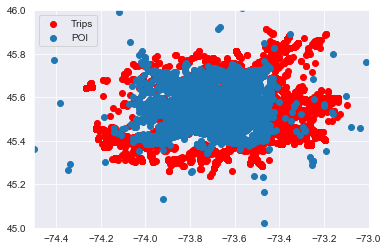

In [281]:
fig, ax = plt.subplots(1)
plt.scatter(gdf_2016['start_wgs'].apply(lambda row: row.x),
            gdf_2016['start_wgs'].apply(lambda row: row.y),color='r', label='Trips')
plt.scatter(mtl_pois['lon'],mtl_pois['lat'], label='POI')
plt.xlim(-74.5,-73)
plt.ylim(45, 46)
plt.legend()

In [299]:
mtl_pois['geometry'] = mtl_pois.apply(lambda row: shapely.geometry.Point(row['lon'], row['lat']), axis=1)
mtl_pois = gpd.GeoDataFrame(mtl_pois)

In [329]:
mtl_pois['geometry'] = mtl_pois['geometry'].apply(lambda row: row.buffer(0.01))

In [335]:
## will need a method that check all trip start and end points eith all the POIs 
## could take hours again...

## Add rush-hour and downtown labels

In [212]:
## downtown
mtl_regions = gpd.read_file('../../Data/shapes/mtl_regions.json')
city_of_montreal = mtl_regions.loc[(mtl_regions.AIRE > 0) & (mtl_regions.TYPE == 'Arrondissement')]

In [213]:
%%time
gdf_2016['start_downtown'] = gdf_2016['start_can'].apply(lambda row: any(city_of_montreal.intersects(row)))
gdf_2016['end_downtown'] = gdf_2016['end_can'].apply(lambda row: any(city_of_montreal.intersects(row)))

gdf_2017['start_downtown'] = gdf_2017['start_can'].apply(lambda row: any(city_of_montreal.intersects(row)))
gdf_2017['end_downtown'] = gdf_2017['end_can'].apply(lambda row: any(city_of_montreal.intersects(row)))

CPU times: user 7min 58s, sys: 2.69 s, total: 8min
Wall time: 8min 7s


In [214]:
print(gdf_2016.start_downtown.value_counts())
print(gdf_2016.end_downtown.value_counts())

print(gdf_2017.start_downtown.value_counts())
print(gdf_2017.end_downtown.value_counts())

True     213076
False     62548
Name: start_downtown, dtype: int64
True     211945
False     63679
Name: end_downtown, dtype: int64
True     159522
False     25763
Name: start_downtown, dtype: int64
True     158477
False     26808
Name: end_downtown, dtype: int64


##### rush hour

In [215]:
if not type(gdf_2016.starttime[0]) == datetime.datetime or not type(gdf_2017.starttime[0]) == datetime.datetime:
    print("converting start and end timestamps to datetime objects")
    gdf_2016['starttime'] = pd.to_datetime(gdf_2016['starttime'])
    gdf_2016['endtime'] = pd.to_datetime(gdf_2016['endtime'])
    gdf_2017['starttime'] = pd.to_datetime(gdf_2017['starttime'])
    gdf_2017['endtime'] = pd.to_datetime(gdf_2017['endtime'])

converting start and end timestamps to datetime objects


In [216]:
gdf_2016['weekday'] = gdf_2016.starttime.apply(lambda dt: dt.dayofweek < 5)
gdf_2017['weekday'] = gdf_2017.starttime.apply(lambda dt: dt.dayofweek < 5)

In [217]:
print(gdf_2016.weekday.value_counts())
print(gdf_2017.weekday.value_counts())

True     211368
False     64256
Name: weekday, dtype: int64
True     137576
False     47709
Name: weekday, dtype: int64


In [218]:
rush_hour_times = {'morning_min':6,'morning_max':10,'evening_min':15, 'evening_max':19}
def rushhour(row):
    """
    function to find out whether trip is in rush hour or not
    """
    start = False
    end = False
    through = False
    if not row.weekday:
        return start, end
    
    if row.starttime.hour >= rush_hour_times['morning_min'] and row.starttime.hour <= rush_hour_times['morning_max']\
    or row.starttime.hour >= rush_hour_times['evening_min'] and row.starttime.hour <= rush_hour_times['evening_max']:
        start = True
    if row.endtime.hour >= rush_hour_times['morning_min'] and row.endtime.hour <= rush_hour_times['morning_max']\
    or row.endtime.hour >= rush_hour_times['evening_min'] and row.endtime.hour <= rush_hour_times['evening_max']:
        end = True
        
    # check if trip passed through rush hours  
    if start and end:
        if row.starttime.hour >= rush_hour_times['morning_min'] and row.endtime.hour <= rush_hour_times['morning_max']\
        or row.starttime.hour >= rush_hour_times['evening_min'] and row.endtime.hour <= rush_hour_times['evening_max']:
            through = True
        
        
    return start, end, through
    

In [219]:
gdf_2016['stend_rh'] = gdf_2016.apply(rushhour, axis=1)
gdf_2017['stend_rh'] = gdf_2017.apply(rushhour, axis=1)

In [220]:
gdf_rushhour_16 = gdf_2016['stend_rh'].apply(pd.Series)
gdf_rushhour_17 = gdf_2017['stend_rh'].apply(pd.Series)

In [221]:
gdf_rushhour_16.columns = ['startrush', 'endrush', 'thrurush']
gdf_rushhour_17.columns = ['startrush', 'endrush', 'thrurush']

In [222]:
gdf_2016 = pd.concat([gdf_2016, gdf_rushhour_16], axis=1)
gdf_2017 = pd.concat([gdf_2017, gdf_rushhour_17], axis=1)

In [227]:
gdf_2016 = gdf_2016.drop('stend_rh',axis=1)
gdf_2017 = gdf_2017.drop('stend_rh',axis=1)

In [364]:
gdf_2016['thrurush'] = gdf_2016['thrurush'].fillna(0).astype(int)
gdf_2017['thrurush'] = gdf_2017['thrurush'].fillna(0).astype(int)

In [223]:
gdf_2016.head()

,id_trip,avg_speed,duration,mode,purpose,n_coord,segments,starttime,endtime,geometry,...,temporal_cluster,land_use_start,land_use_end,start_downtown,end_downtown,weekday,stend_rh,startrush,endrush,thrurush
0,1724206,4.4,460,walking,returning_home,12,"[{""id"": 1150192, ""source"": ""geobase_mtl""}, {""i...",2016-09-07 20:37:26,2016-09-07 20:45:06,LINESTRING (7628287.236741195 1247680.17623496...,...,3,residential,residential,True,True,True,"(False, False, False)",False,False,False
1,1724208,10.7,2146,combination,work,120,"[{""id"": 1140016, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 07:43:23,2016-09-08 08:19:09,LINESTRING (7627830.069607561 1247172.27553199...,...,2,residential,institution,True,True,True,"(True, True, True)",True,True,True
2,1889461,15.4,447,public_transport,leisure,36,"[{""id"": 1390715, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 19:46:14,2016-09-08 19:53:41,LINESTRING (7632055.840015981 1247584.15415876...,...,5,mixed,mixed,True,True,True,"(True, True, True)",True,True,True
3,1724219,16.8,591,car,returning_home,45,"[{""id"": 1210250, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 21:41:37,2016-09-08 21:51:28,LINESTRING (7630236.131991105 1247926.25343474...,...,3,mixed,residential,True,True,True,"(False, False, False)",False,False,False
4,2071985,6.9,279,combination,pick_up_drop_off,12,"[{""id"": 1140287, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 16:49:12,2016-09-09 16:53:51,LINESTRING (7628479.88311419 1247193.386491392...,...,5,residential,residential,True,True,True,"(True, True, True)",True,True,True


In [229]:
gdf_2017.head()

,id_trip,mode,purpose,starttime,endtime,geometry,precip,temperature,distance_m,duration,...,lda_word,temporal_cluster,land_use_start,land_use_end,start_downtown,end_downtown,weekday,startrush,endrush,thrurush
0,1547,None,None,2017-09-18 04:16:58,2017-09-18 04:26:26,LINESTRING (7624015.797731057 1247372.35912241...,0.0,18.951944,1530.222174,568,...,None,0,employment,employment,True,True,True,False,False,False
1,308312,None,None,2017-09-18 06:17:46,2017-09-18 06:58:49,LINESTRING (7624029.565886397 1247375.82561127...,0.0,18.353766,324.869460,2463,...,None,0,employment,employment,True,True,True,True,True,True
2,384772,None,None,2017-09-18 09:30:24,2017-09-18 10:17:28,(LINESTRING (7607307.107749196 1253237.7069476...,0.0,16.910884,32009.701647,2824,...,None,0,0,0,False,True,True,True,True,True
3,150744,car,pick_up_drop_off,2017-09-18 10:02:50,2017-09-18 10:17:12,LINESTRING (7624322.265039736 1247672.97005954...,0.0,16.910884,9935.922336,862,...,"Monday_10, pick_up_drop_off",4,residential,residential,True,True,True,True,True,True
4,199011,None,None,2017-09-18 10:18:40,2017-09-18 10:27:44,(LINESTRING (7616402.393582946 1246769.1996916...,0.0,16.910884,563.806088,544,...,None,0,0,0,False,False,True,True,True,True


## Clean & Subset data

##### check geometry types & standardise them (unfinished)

In [338]:
gdf_2016['geometry'].apply(lambda row: type(row)).unique()

array([<class 'shapely.geometry.linestring.LineString'>,
       <class 'shapely.geometry.multilinestring.MultiLineString'>],
      dtype=object)

In [339]:
gdf_2017['geometry'].apply(lambda row: type(row)).unique()

array([<class 'shapely.geometry.linestring.LineString'>,
       <class 'shapely.geometry.multilinestring.MultiLineString'>],
      dtype=object)

##### remove mode and purpose not shared between years
NOTE: move this to the start

In [6]:
# create sets
set_2016_md = set(gdf_2016['mode'].unique())
set_2017_md = set(gdf_2017['mode'].unique())

set_2016_pur = set(gdf_2016['purpose'].unique())
set_2017_pur = set(gdf_2017['purpose'].unique())

In [7]:
mode_not_in_2016 = list(set_2017_md.difference(set_2016_md))
purpose_not_in_2016 = list(set_2017_pur.difference(set_2016_pur))
mode_not_in_2017 = list(set_2016_md.difference(set_2017_md))
purpose_not_in_2017 = list(set_2016_pur.difference(set_2017_pur))

In [8]:
# mode values to drop
len(gdf_2017.loc[(gdf_2017['mode'].apply(lambda row: row in mode_not_in_2016))])

10737

In [13]:
# purpose values to drop
len(gdf_2017.loc[(gdf_2017['purpose'].apply(lambda row: row in purpose_not_in_2016))])

1244

In [9]:
purpose_not_in_2016

['not_available', 'other']

In [10]:
mode_not_in_2016[:5] + ['...']

['taxi, public_transport',
 'public_transport, car, cycling',
 'taxi, public_transport, car',
 'not_available',
 'other, public_transport, cycling',
 '...']

In [11]:
mode_not_in_2017

['combination']

In [12]:
## total trips were multi-mode is chosen
len(np.where(gdf_2017.dropna()['mode'].apply(lambda row: ',' in row))[0])

8595

In [13]:
## get all values where mode and purpose are in 2016 and 2017 and not None
gdf_2016 = gdf_2016.loc[(gdf_2016['purpose'].apply(lambda row: row not in list(purpose_not_in_2017)))&
             (gdf_2016['mode'].apply(lambda row: row not in list(mode_not_in_2017)))&
             (gdf_2016['purpose'])&(gdf_2016['mode'])]

In [14]:
## get all values where mode and purpose are in 2016 and 2017 and not None
gdf_2017 = gdf_2017.loc[(gdf_2017['purpose'].apply(lambda row: row not in list(purpose_not_in_2016)))&
             (gdf_2017['mode'].apply(lambda row: row not in list(mode_not_in_2016)))&
             (gdf_2017['purpose'])&(gdf_2017['mode'])]

### remove outliers
50 m >= Distance <= 100 km  
60 sec >= Duration <= 180 mins 

In [15]:
print(len(gdf_2016)) ## 56500
print(len(gdf_2017)) ## 62421

56500
62421


In [16]:
# outlier removal
gdf_2016 = gdf_2016.loc[gdf_2016.distance_m >= 50]
gdf_2016 = gdf_2016.loc[gdf_2016.duration >= 60]
gdf_2016 = gdf_2016.loc[gdf_2016.distance_m <= 100000]
gdf_2016 = gdf_2016.loc[gdf_2016.duration <= 10800]
gdf_2016 = gdf_2016.dropna(subset=['mode'])
gdf_2016 = gdf_2016.reset_index(drop=True)

gdf_2017 = gdf_2017.loc[gdf_2017.distance_m >= 50]
gdf_2017 = gdf_2017.loc[gdf_2017.duration >= 60]
gdf_2017 = gdf_2017.loc[gdf_2017.distance_m <= 100000]
gdf_2017 = gdf_2017.loc[gdf_2017.duration <= 10800]
gdf_2017 = gdf_2017.dropna(subset=['mode'])
gdf_2017 = gdf_2017.reset_index(drop=True)

In [435]:
print(len(gdf_2016)) ## 56340 
print(len(gdf_2017)) ## 61391

56340
61391


## create model inputs

In [253]:
### CURRENTLY DEFUNCT CODE
## IMPORTANT: Needed if saving data to file and reloading it:
if not 'land_use_s' in gdf_2016.columns:
    print('renaming')
    gdf_2016.rename(columns={'land_use_start':'land_use_s','land_use_end':'land_use_e'}, inplace=True)
    
if not 'land_use_s' in gdf_2017.columns:
    print('renaming')
    gdf_2016.rename(columns={'land_use_start':'land_use_s','land_use_end':'land_use_e'}, inplace=True)

In [403]:
# create common factors across the datasets (these need to be copied)
class ModelInputs:
    def __init__(self, data):
        self.data = data.copy()
        ## for oversampling
#         self.ros = RandomOverSampler(random_state=0)
        
    def create_factor_dicts(self):
        self.mode_factors = {}
        for i, md in enumerate(pd.factorize(self.data['mode'])[1]):
            self.mode_factors[md] = i

        self.land_use_factors = {}
        for i, md in enumerate(pd.factorize(self.data['land_use_s'])[1]):
            self.land_use_factors[md] = i

        self.purpose_factors = {}
        for i, pr in enumerate(pd.factorize(self.data['purpose'])[1]):
            self.purpose_factors[pr] = i

        self.carddir_factors = {}
        for i, md in enumerate(pd.factorize(self.data['carddir'])[1]):
            self.carddir_factors[md] = i
    
    def factorisation(self, row, col):
        """function to map dictionaries to the data"""
        if col == 'land_use':
            return self.land_use_factors[row]
        elif col == 'purpose':
            return self.purpose_factors[row]
        elif col == 'mode':
            return self.mode_factors[row]
        elif col == 'carddir':
            return self.carddir_factors[row]
        
    def print_all_factors(self):
        print(self.land_use_factors, self.purpose_factors, self.mode_factors, self.carddir_factors)
    
    def model_setup(self, norm=False, oversample=False):
        create_factor_dicts(self.data)
        self.data['land_use_s_f'] = self.data['land_use_s'].apply(self.factorisation, args=('land_use',))
        self.data['land_use_e_f'] = self.data['land_use_e'].apply(self.factorisation, args=('land_use',))
        self.data['purpose_f'] = self.data['purpose'].apply(self.factorisation, args=('purpose',))
        self.data['mode_f'] = self.data['mode'].apply(self.factorisation, args=('mode',))
        self.data['carddir_f'] = self.data['carddir'].apply(self.factorisation, args=('carddir',))

        self.X = self.data[['id_trip',"mode_f","duration","distance_m","magnitude","carddir_f","start_down",\
              "end_downto","weekday", "temporal_c","precip","temperatur",\
            "startrush","endrush","thrurush","startclust","endclust","land_use_s_f","land_use_e_f"]]
        self.y = self.data[["purpose_f"]] # purpose_labels
        self.X.weekday = self.X.weekday.astype(int)
    #     X = np.nan_to_num(X)
        self.feature_list = list(self.X.columns)
        if oversample:
            print('oversampling...')
            self.X, self.y = ros.fit_resample(self.X, self.y)
        if norm:
            self.X = normalise(self.X)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.33, random_state=42)

    @classmethod
    def normalise():
        self.X = self.X / np.amax(self.X, axis=0)
        
    def encode_inputs(self):
        non_code_columns = ["mode_f","carddir_f","startclust","endclust", "purpose_f", "id_trip",'starttime','endtime', 'segments','geometry', 'mode', 'purpose', 'carddir', 'start_wgs', 'end_wgs', 'start_can', 'end_can','lda_word','land_use_s', 'land_use_e']
        enc = OneHotEncoder(handle_unknown='ignore')
        mode_codes = np.array([])
        carddir_codes = np.array([])
        stcl_codes = np.array([])
        encl_codes = np.array([])
        land_use_start_codes = np.array([])
        land_use_end_codes = np.array([])
        if 'mode_f' in self.data.columns:
            mode_codes = enc.fit_transform(self.data['mode_f'].values.reshape(-1, 1)).toarray()
        elif 'land_use_s_f' in self.data.columns:
            self.data['land_use_s_f'] = self.data['land_use_s_f'].astype(int)
            land_use_start_codes = enc.fit_transform(self.data['land_use_s_f'].values.reshape(-1, 1)).toarray()
        elif 'land_use_e_f' in self.data.columns:
            self.data['land_use_e_f'] = self.data['land_use_e_f'].astype(int)
            land_use_end_codes = enc.fit_transform(self.data['land_use_e_f'].values.reshape(-1, 1)).toarray()
        elif 'carddir_f' in self.data.columns:
            carddir_codes = enc.fit_transform(self.data['carddir_f'].values.reshape(-1, 1)).toarray()
        elif 'startclust' in self.data.columns:
            stcl_codes = enc.fit_transform(self.data['startclust'].values.reshape(-1, 1)).toarray()
        elif 'endclust' in self.data.columns:
            encl_codes = enc.fit_transform(self.data['endclust'].values.reshape(-1, 1)).toarray()
        if 'weekday' in self.data.columns:
            self.data['weekday'] = self.data['weekday'].astype(int)
            
        self.y_codes = enc.fit_transform(self.data['purpose_f'].values.reshape(-1, 1)).toarray()

        unique_ids = self.data['id_trip'].values.reshape(-1,1)
        non_codes = self.data[self.data.columns[[col not in non_code_columns for col in self.data.columns]]]
        feature_list = list(non_codes)
        non_codes = non_codes.values
        
        # normalise
        self.non_codes = non_codes
        non_codes = non_codes / np.amax(non_codes, axis=0)
        other_inputs = {}
        # only return codes that are above 0.05 importance
        for i, cds in enumerate([non_codes, mode_codes, carddir_codes, stcl_codes, encl_codes, land_use_start_codes, land_use_end_codes, unique_ids]):
            if len(cds) != 0:
                other_inputs[i] = cds
        self.other_inputs = np.concatenate(tuple(other_inputs.values()), axis=1)

In [404]:
gdf_2016_data_inputs = ModelInputs(gdf_2016)

In [405]:
gdf_2016_data_inputs.create_factor_dicts()

In [406]:
gdf_2016_data_inputs.carddir_factors

{'NW': 0,
 'WNW': 1,
 'W': 2,
 'ESE': 3,
 'NNE': 4,
 'ENE': 5,
 'SSW': 6,
 'SE': 7,
 'SW': 8,
 'WSW': 9,
 'N': 10,
 'SSE': 11,
 'NNW': 12,
 'S': 13,
 'E': 14,
 'NE': 15}

In [407]:
gdf_2016_data_inputs.land_use_factors

{'residential': 0,
 'mixed': 1,
 'conservation': 2,
 'institution': 3,
 'park': 4,
 '0': 5,
 'employment': 6,
 'diversified activities': 7,
 'religious': 8,
 'infrastructure': 9}

In [408]:
gdf_2016_data_inputs.model_setup()

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [409]:
gdf_2016_data_inputs.encode_inputs()

In [410]:
gdf_2016_data_inputs.print_all_factors()

{'residential': 0, 'mixed': 1, 'conservation': 2, 'institution': 3, 'park': 4, '0': 5, 'employment': 6, 'diversified activities': 7, 'religious': 8, 'infrastructure': 9} {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4, 'pick_up_drop_off': 5, 'education': 6, 'health': 7} {'walking': 0, 'public_transport': 1, 'car': 2, 'cycling': 3, 'public_transport, car': 4, 'other': 5} {'NW': 0, 'WNW': 1, 'W': 2, 'ESE': 3, 'NNE': 4, 'ENE': 5, 'SSW': 6, 'SE': 7, 'SW': 8, 'WSW': 9, 'N': 10, 'SSE': 11, 'NNW': 12, 'S': 13, 'E': 14, 'NE': 15}


In [411]:
X_train = gdf_2016_data_inputs.X_train
X_test = gdf_2016_data_inputs.X_test
y_train = gdf_2016_data_inputs.y_train
y_test = gdf_2016_data_inputs.y_test
feature_list = gdf_2016_data_inputs.feature_list

In [412]:
gdf_2016_data_inputs.y

,purpose_f
0,0
1,1
2,0
3,2
4,2
5,0
6,0
7,2
8,1
9,1


## save final preprocessed data

#### factorisation

In [427]:
gdf_2016_data_inputs.purpose_factors

{'returning_home': 0,
 'leisure': 1,
 'food_drink': 2,
 'shops': 3,
 'work': 4,
 'pick_up_drop_off': 5,
 'education': 6,
 'health': 7}

In [430]:
## save X & y data
for nm, df in zip(['gdf_2016', 'gdf_2017'], [gdf_2016, gdf_2017]):
    data_inputs = ModelInputs(df)
    data_inputs.create_factor_dicts()
    with open('../../Data/model_inputs/{0}_carddir_factors.txt'.format(nm), 'w') as my_file:
        my_file.write(str(data_inputs.carddir_factors))
        my_file.close()
    
    with open('../../Data/model_inputs/{0}_mode_factors.txt'.format(nm), 'w') as my_file:
        my_file.write(str(data_inputs.mode_factors))
        my_file.close()

    with open('../../Data/model_inputs/{0}_land_use_factors.txt'.format(nm), 'w') as my_file:
        my_file.write(str(data_inputs.land_use_factors))
        my_file.close()

    with open('../../Data/model_inputs/{0}_purpose_factors.txt'.format(nm), 'w') as my_file:
        my_file.write(str(data_inputs.purpose_factors))
        my_file.close()
    
    data_inputs.model_setup()
    data_inputs.X.to_csv('../../Data/model_inputs/{0}_X.csv'.format(nm), index=False)
    data_inputs.y.to_csv('../../Data/model_inputs/{0}_y.csv'.format(nm), index=False)

##### non-factorised:

In [436]:
gdf_2016['starttime'] = gdf_2016['starttime'].astype(str)
gdf_2016['endtime'] = gdf_2016['endtime'].astype(str)
gdf_2017['starttime'] = gdf_2017['starttime'].astype(str)
gdf_2017['endtime'] = gdf_2017['endtime'].astype(str)

gdf_2016['start_can'] = gdf_2016['start_can'].astype(str)
gdf_2016['end_can'] = gdf_2016['end_can'].astype(str)
gdf_2016['start_wgs'] = gdf_2016['start_wgs'].astype(str)
gdf_2016['end_wgs'] = gdf_2016['end_wgs'].astype(str)

gdf_2017['start_can'] = gdf_2017['start_can'].astype(str)
gdf_2017['end_can'] = gdf_2017['end_can'].astype(str)
gdf_2017['start_wgs'] = gdf_2017['start_wgs'].astype(str)
gdf_2017['end_wgs'] = gdf_2017['end_wgs'].astype(str)

# path to the preprocessed MTL Trajet data 
path_final_2016 = "../../Data/mtl_trajet/mtl_trajet_2016_final.shp"
path_final_2017 = "../../Data/mtl_trajet/mtl_trajet_2017_final.shp"

gdf_2016.to_file(path_final_2016, encoding='utf-8')
gdf_2017.to_file(path_final_2017, encoding='utf-8')

### test data

In [437]:
# path to the MTL Trajet data 
path_2016 = "../../Data/mtl_trajet/mtl_trajet_2016_final.shp"
path_2017 = "../../Data/mtl_trajet/mtl_trajet_2017_final.shp"

In [441]:
gdf_2016 = preprocessing.translate.translate_data(path_2016)
gdf_2017 = preprocessing.translate.translate_data(path_2017)

gdf_2016['starttime'] = pd.to_datetime(gdf_2016['starttime'])
gdf_2016['endtime'] = pd.to_datetime(gdf_2016['endtime'])
gdf_2017['starttime'] = pd.to_datetime(gdf_2017['starttime'])
gdf_2017['endtime'] = pd.to_datetime(gdf_2017['endtime'])

gdf_2016['start_can'] = gdf_2016['start_can'].apply(wkt.loads)
gdf_2016['end_can'] = gdf_2016['end_can'].apply(wkt.loads)
gdf_2017['start_can'] = gdf_2017['start_can'].apply(wkt.loads)
gdf_2017['end_can'] = gdf_2017['end_can'].apply(wkt.loads)
gdf_2016['start_wgs'] = gdf_2016['start_wgs'].apply(wkt.loads)
gdf_2016['end_wgs'] = gdf_2016['end_wgs'].apply(wkt.loads)
gdf_2017['start_wgs'] = gdf_2017['start_wgs'].apply(wkt.loads)
gdf_2017['end_wgs'] = gdf_2017['end_wgs'].apply(wkt.loads)

In [442]:
gdf_2016

,id_trip,avg_speed,duration,mode,purpose,n_coord,segments,starttime,endtime,precip,...,temporal_c,land_use_s,land_use_e,start_down,end_downto,weekday,startrush,endrush,thrurush,geometry
0,1724206,4.4,460,walking,returning_home,12,"[{""id"": 1150192, ""source"": ""geobase_mtl""}, {""i...",2016-09-07 20:37:26,2016-09-07 20:45:06,1.503944e-06,...,3,residential,residential,1,1,1,0,0,0,LINESTRING (7628287.236741195 1247680.17623496...
1,1889461,15.4,447,public_transport,leisure,36,"[{""id"": 1390715, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 19:46:14,2016-09-08 19:53:41,1.343524e-04,...,5,mixed,mixed,1,1,1,1,1,1,LINESTRING (7632055.840015981 1247584.15415876...
2,1724219,16.8,591,car,returning_home,45,"[{""id"": 1210250, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 21:41:37,2016-09-08 21:51:28,2.401298e-04,...,3,mixed,residential,1,1,1,0,0,0,LINESTRING (7630236.131991105 1247926.25343474...
3,2071991,12.4,844,cycling,food_drink,56,"[{""id"": 1150004, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 18:22:22,2016-09-09 18:36:26,1.427243e-03,...,5,residential,park,1,1,1,1,1,1,LINESTRING (7628002.075274518 1247761.31724215...
4,1667922,4.2,1211,cycling,food_drink,29,"[{""id"": 1240379, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 23:41:59,2016-09-10 00:02:10,1.428747e-03,...,4,residential,residential,1,1,1,0,0,0,LINESTRING (7628517.528697009 1246292.61362128...
5,1667924,3.9,1330,walking,returning_home,29,"[{""id"": 1220168, ""source"": ""geobase_mtl""}, {""i...",2016-09-10 00:10:40,2016-09-10 00:32:50,1.428747e-03,...,4,mixed,mixed,1,1,0,0,0,None,LINESTRING (7629840.839065068 1246606.40804376...
6,2071994,9.8,930,cycling,returning_home,49,"[{""id"": 1120087, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 20:04:18,2016-09-09 20:19:48,1.427745e-03,...,3,residential,residential,1,1,1,0,0,0,LINESTRING (7626472.681291105 1247124.48181703...
7,2072003,4.8,1266,walking,food_drink,34,"[{""id"": 5640, ""source"": ""reseau_cyclable""}, {""...",2016-09-10 10:29:44,2016-09-10 10:50:50,0.000000e+00,...,2,residential,residential,1,1,0,0,0,None,LINESTRING (7628222.92791587 1247461.407682431...
8,2072007,4.5,603,walking,leisure,16,"[{""id"": 1240255, ""source"": ""geobase_mtl""}, {""i...",2016-09-10 13:06:26,2016-09-10 13:16:29,0.000000e+00,...,5,mixed,conservation,1,1,0,0,0,None,LINESTRING (7629631.088157225 1245856.46655085...
9,2072009,4.9,529,walking,leisure,15,"[{""id"": 1441, ""source"": ""reseau_cyclable""}, {""...",2016-09-10 14:21:56,2016-09-10 14:30:45,0.000000e+00,...,5,conservation,mixed,1,1,0,0,0,None,LINESTRING (7630255.449387748 1245554.79842293...


In [458]:
gdf_2017

,id_trip,mode,purpose,starttime,endtime,precip,temperatur,distance_m,duration,direction,...,temporal_c,land_use_s,land_use_e,start_down,end_downto,weekday,startrush,endrush,thrurush,geometry
0,150744,car,pick_up_drop_off,2017-09-18 10:02:50,2017-09-18 10:17:12,0.000000e+00,16.910884,9935.922336,862,85.310969,...,4,residential,residential,1,1,1,1,1,1,LINESTRING (7624322.265039736 1247672.97005954...
1,173651,car,work,2017-09-18 11:14:10,2017-09-18 12:01:46,9.972328e-07,18.007062,15283.760539,2856,171.872470,...,2,0,0,0,0,1,0,0,0,LINESTRING (7608401.682399749 1254568.51545545...
2,149086,public_transport,work,2017-09-18 11:20:42,2017-09-18 12:10:14,9.972328e-07,18.007062,7693.525202,2972,170.378606,...,2,mixed,mixed,1,1,1,0,0,0,LINESTRING (7631576.524534984 1246305.00154663...
3,358412,walking,work,2017-09-18 11:27:38,2017-09-18 11:40:26,9.972328e-07,16.815241,992.314303,768,211.576183,...,2,employment,mixed,1,1,1,0,0,0,LINESTRING (7629026.97298938 1247452.253998657...
4,350121,car,work,2017-09-18 11:31:56,2017-09-18 12:11:26,9.972328e-07,18.007062,33250.148027,2370,195.329388,...,2,0,0,0,0,1,0,0,0,(LINESTRING (7658025.534948333 1258938.3229502...
5,35763,car,shops,2017-09-18 11:32:54,2017-09-18 12:04:07,9.972328e-07,18.007062,6832.113937,1873,338.681845,...,2,0,0,0,0,1,0,0,0,LINESTRING (7641918.591122855 1236660.83022969...
6,230363,public_transport,work,2017-09-18 11:33:37,2017-09-18 12:16:09,9.972328e-07,18.007062,8500.854359,2552,127.802412,...,2,residential,mixed,1,1,1,0,0,0,(LINESTRING (7625449.252399735 1247376.6710083...
7,223745,walking,work,2017-09-18 11:36:48,2017-09-18 11:42:12,9.972328e-07,16.815241,216.682653,324,213.081606,...,2,residential,residential,1,1,1,0,0,0,LINESTRING (7627349.52474691 1247846.195735047...
8,17106,cycling,work,2017-09-18 11:44:21,2017-09-18 12:27:02,9.972328e-07,18.007062,15794.079345,2561,184.728074,...,2,employment,employment,1,1,1,0,0,0,(LINESTRING (7631777.817984976 1256178.4640900...
9,321720,car,work,2017-09-18 11:45:19,2017-09-18 12:17:40,9.972328e-07,18.007062,15110.400096,1941,63.855255,...,2,mixed,0,1,0,1,0,0,0,LINESTRING (7629699.82108405 1249470.868708408...


In [457]:
gdf_2017['precip'].isna().value_counts()

False    61263
True       128
Name: precip, dtype: int64